In [1]:
import cv2
import math
import torch
import argparse
import numpy as np

from PIL import Image
from monodepth2.infer import infer_depth
from yolact.infer import infer_segmentation

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_res(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img)
    
    with torch.no_grad():
        depth_map, depth_im = infer_depth("mono+stereo_1024x320", img_pil)
        masks, masks_im = infer_segmentation("yolact_plus_resnet50_54_800000.pth", img)
        depth_map = depth_map[0, 0]# * 5.4
        
    res_img = img.copy()
    colors = np.random.randint(0, 255, (masks.shape[0], 3))

    i = 0
    for m, c in zip(masks, colors):
        i+=1
        person_depth = depth_map * np.squeeze(m, -1)
        try:
            avg_depth = person_depth[np.where(person_depth != 0)].mean()
            x, y = int(np.where(person_depth != 0)[0].mean()), int(np.where(person_depth != 0)[1].mean())
        except ValueError:
            #invalid avg_depth
            continue
        
        CENTER = (y, x)
        res_img = cv2.circle(res_img, CENTER, int(math.e ** (-avg_depth/2) * 100), tuple([int(x) for x in c]), -1)

        TEXT_FACE = cv2.FONT_HERSHEY_DUPLEX
        TEXT_SCALE = 0.8 * (10 - avg_depth) / 10
        TEXT_THICKNESS = 1
        TEXT = f"{avg_depth:.2f}m"

        text_size, _ = cv2.getTextSize(TEXT, TEXT_FACE, TEXT_SCALE, TEXT_THICKNESS)
        text_origin = (CENTER[0] - text_size[0] // 2, CENTER[1] + text_size[1] // 2)
        cv2.putText(res_img, TEXT, text_origin, TEXT_FACE, TEXT_SCALE, (255,255,255), TEXT_THICKNESS, cv2.LINE_AA)

        res_img = cv2.addWeighted(res_img, 1, (c * np.concatenate([m, m, m], -1)).astype(np.uint8), 0.3, 0)
        
    return img, res_img, depth_im, masks_im, depth_map

In [3]:
def merge_masks(masks):
    n_masks = np.concatenate([masks, masks, masks], -1)
    merged = np.zeros((n_masks.shape[1:]))
    colors = np.random.randint(0, 255, (n_masks.shape[0], 3))
    for m, c in zip(n_masks, colors):
        merged += c * m
        
    return merged.astype(int)

## Read Input Data

In [4]:
image = cv2.imread('a.jpg')

img, res_img, depth_im, masks_im, depth_map = get_res(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

-> Loading model from  models/mono+stereo_1024x320
   Loading pretrained encoder
   Loading pretrained decoder
-> Loading model from  models/yolact_plus_resnet50_54_800000.pth
   Loading pretrained model


/Users/enisimsar/miniconda3/envs/yolo-env/lib/python3.7/site-packages/torch/jit/_recursive.py:152: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/Users/enisimsar/miniconda3/envs/yolo-env/lib/python3.7/site-packages/torch/jit/_recursive.py:152: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/Users/enisimsar/miniconda3/envs/yolo-env/lib/python3.7/site-packages/torch/jit/_recursive.py:152: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


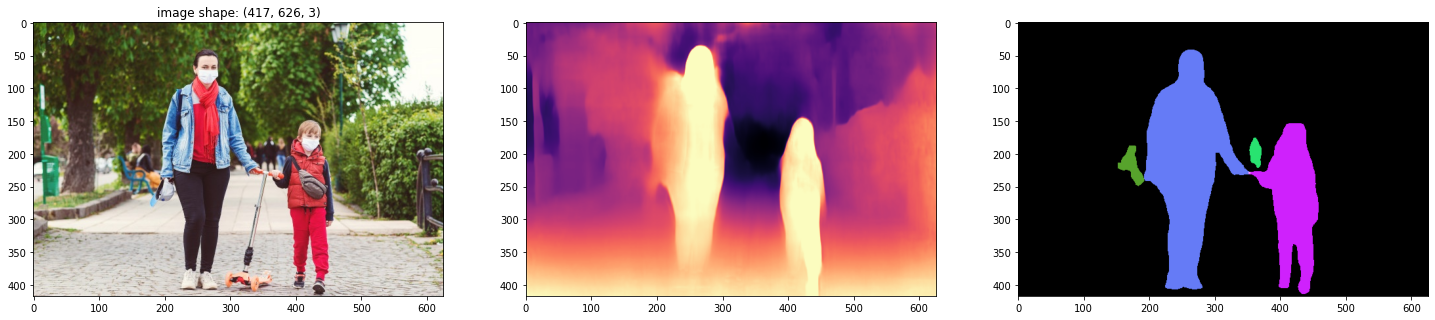

In [5]:
plt.figure(figsize=(25,10))

plt.subplot(1, 3, 1)
plt.title(f"image shape: {image.shape}")
plt.imshow(img)

plt.subplot(1, 3, 2)
# plt.title(f"depth map shape: {depth_im.shape}")
plt.imshow(depth_im)

plt.subplot(1, 3, 3)
# plt.title(f"masks shape: {masks_im.shape}")
plt.imshow(masks_im)

In [6]:
depth_im.save('depths.png')
Image.fromarray(masks_im.astype(np.uint8)).save('masks.png')

In [7]:
c = masks_im[150, 250]

In [8]:
x, y, _ = np.where(masks_im == c)

In [9]:
k= np.zeros_like(depth_im)
k[x, y] = 1
mask = k * c

In [10]:
mask.shape

(417, 626, 3)

In [11]:
Image.fromarray((k * depth_im).astype(np.uint8)).save('depth.png')
Image.fromarray(mask.astype(np.uint8)).save('mask.png')

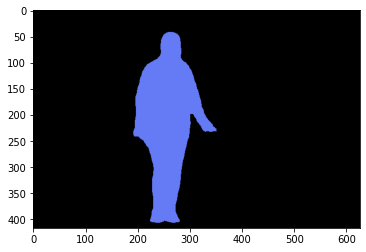

In [12]:
plt.imshow(mask)

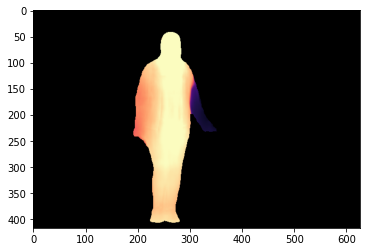

In [13]:
plt.imshow(k * depth_im)

In [14]:
np.array(depth_im)[x, y]

array([[251, 252, 191],
       [251, 252, 191],
       [251, 252, 191],
       ...,
       [253, 223, 161],
       [253, 223, 161],
       [253, 223, 161]], dtype=uint8)

In [15]:
m = mask


In [16]:
person_depth = depth_map #*m#* np.squeeze(m, -1)
avg_depth = person_depth[np.where(person_depth != 0)].mean()
x, y = int(np.where(person_depth != 0)[0].mean()), int(np.where(person_depth != 0)[1].mean())

CENTER = (250, 200)
res_img = cv2.circle(image, CENTER, int(math.e ** (-avg_depth/2) * 100), tuple([int(x) for x in c]), -1)

TEXT_FACE = cv2.FONT_HERSHEY_DUPLEX
TEXT_SCALE = 0.8 * (10 - avg_depth) / 10
TEXT_THICKNESS = 1
TEXT = f"{avg_depth:.2f}m"

text_size, _ = cv2.getTextSize(TEXT, TEXT_FACE, TEXT_SCALE, TEXT_THICKNESS)
text_origin = (CENTER[0] - text_size[0] // 2, CENTER[1] + text_size[1] // 2)
cv2.putText(image, TEXT, text_origin, TEXT_FACE, TEXT_SCALE, (255,255,255), TEXT_THICKNESS, cv2.LINE_AA)

image = cv2.addWeighted(image, 1, (m).astype(np.uint8), 0.3, 0)

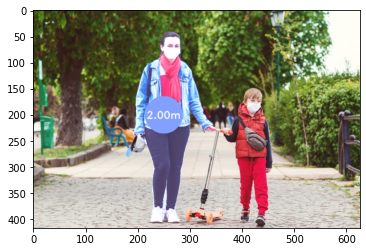

In [17]:
plt.imshow(image)

In [19]:
Image.fromarray(image.astype(np.uint8)).save('image.png')